In [1]:
# library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:

images_path = Path('/content/drive/My Drive/CS545/images')
anno_path = Path('/content/drive/My Drive/CS545/labels')

In [4]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = 'finger'
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

df_train = generate_train_df(anno_path)
print(df_train)

                                            filename width height   class  \
0     /content/drive/My Drive/CS545/images/23f45.jpg   640    480  finger   
1     /content/drive/My Drive/CS545/images/34f15.jpg   640    480  finger   
2     /content/drive/My Drive/CS545/images/10f10.jpg   640    480  finger   
3     /content/drive/My Drive/CS545/images/10f25.jpg   640    480  finger   
4     /content/drive/My Drive/CS545/images/10f40.jpg   640    480  finger   
..                                               ...   ...    ...     ...   
981   /content/drive/My Drive/CS545/images/100f6.jpg   640    480  finger   
982   /content/drive/My Drive/CS545/images/100f9.jpg   640    480  finger   
983  /content/drive/My Drive/CS545/images/100f12.jpg   640    480  finger   
984  /content/drive/My Drive/CS545/images/100f15.jpg   640    480  finger   
985  /content/drive/My Drive/CS545/images/100f18.jpg   640    480  finger   

     xmin  ymin  xmax  ymax  
0     194   446   236   480  
1     249   284

In [5]:
# label encode target
class_dict = {'finger': 0}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [6]:
print(df_train.shape)
df_train.head()


(986, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/My Drive/CS545/images/23f45.jpg,640,480,0,194,446,236,480
1,/content/drive/My Drive/CS545/images/34f15.jpg,640,480,0,249,284,275,315
2,/content/drive/My Drive/CS545/images/10f10.jpg,640,480,0,210,243,247,271
3,/content/drive/My Drive/CS545/images/10f25.jpg,640,480,0,113,206,149,234
4,/content/drive/My Drive/CS545/images/10f40.jpg,640,480,0,257,291,285,321


# Resizing images and bounding boxes

In [7]:
# Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int32)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [8]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))

    return new_path, mask_to_bb(Y_resized)

In [9]:
!ls

drive  sample_data


In [10]:
# Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('.')

for index, row in df_train.iterrows():
    # print(row.values[4:8])
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    # print(new_path)
    new_paths.append(new_path)
    new_bbs.append(new_bb)

df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

print(df_train)

                                            filename width height  class  \
0     /content/drive/My Drive/CS545/images/23f45.jpg   640    480      0   
1     /content/drive/My Drive/CS545/images/34f15.jpg   640    480      0   
2     /content/drive/My Drive/CS545/images/10f10.jpg   640    480      0   
3     /content/drive/My Drive/CS545/images/10f25.jpg   640    480      0   
4     /content/drive/My Drive/CS545/images/10f40.jpg   640    480      0   
..                                               ...   ...    ...    ...   
981   /content/drive/My Drive/CS545/images/100f6.jpg   640    480      0   
982   /content/drive/My Drive/CS545/images/100f9.jpg   640    480      0   
983  /content/drive/My Drive/CS545/images/100f12.jpg   640    480      0   
984  /content/drive/My Drive/CS545/images/100f15.jpg   640    480      0   
985  /content/drive/My Drive/CS545/images/100f18.jpg   640    480      0   

     xmin  ymin  xmax  ymax    new_path                        new_bb  
0     194   446

## Sample Image

In [11]:
!ls '/content/drive/My Drive/CS545/images'

100f0.jpg   1f15.jpg   2f21.jpg   3f27.jpg   4f35.jpg	5f3.jpg    6f45.jpg   7f6.jpg	 90f10.jpg
100f10.jpg  1f18.jpg   2f24.jpg   3f30.jpg   4f36.jpg	5f40.jpg   6f48.jpg   7f9.jpg	 90f12.jpg
100f12.jpg  1f20.jpg   2f25.jpg   3f33.jpg   4f39.jpg	5f42.jpg   6f5.jpg    80f0.jpg	 90f15.jpg
100f15.jpg  1f21.jpg   2f27.jpg   3f35.jpg   4f3.jpg	5f45.jpg   6f6.jpg    80f10.jpg  90f18.jpg
100f18.jpg  1f24.jpg   2f30.jpg   3f36.jpg   4f40.jpg	5f48.jpg   6f9.jpg    80f12.jpg  90f20.jpg
100f20.jpg  1f25.jpg   2f33.jpg   3f39.jpg   4f42.jpg	5f5.jpg    70f0.jpg   80f15.jpg  90f21.jpg
100f21.jpg  1f27.jpg   2f35.jpg   3f3.jpg    4f45.jpg	5f6.jpg    70f10.jpg  80f18.jpg  90f24.jpg
100f24.jpg  1f30.jpg   2f36.jpg   3f40.jpg   4f48.jpg	5f9.jpg    70f12.jpg  80f20.jpg  90f25.jpg
100f25.jpg  1f33.jpg   2f39.jpg   3f42.jpg   4f5.jpg	60f0.jpg   70f15.jpg  80f21.jpg  90f27.jpg
100f27.jpg  1f35.jpg   2f3.jpg	  3f45.jpg   4f6.jpg	60f10.jpg  70f18.jpg  80f24.jpg  90f30.jpg
100f30.jpg  1f36.jpg   2f40.jpg   3f48.

In [12]:
print(df_train.values[300][4])
im = cv2.imread(str(df_train.values[400][0]))
bb = create_bb_array(df_train.values[400])
print(df_train.values[400])
print(bb)
print(im.shape)

444
[PosixPath('/content/drive/My Drive/CS545/images/71f5.jpg') '640' '480' 0
 44 219 77 256 '71f5.jpg' array([137.,  30., 159.,  53.], dtype=float32)]
[219  44 256  77]
(480, 640, 3)


In [13]:
Y = create_mask(bb, im)
mask_to_bb(Y)




array([219.,  44., 255.,  76.], dtype=float32)

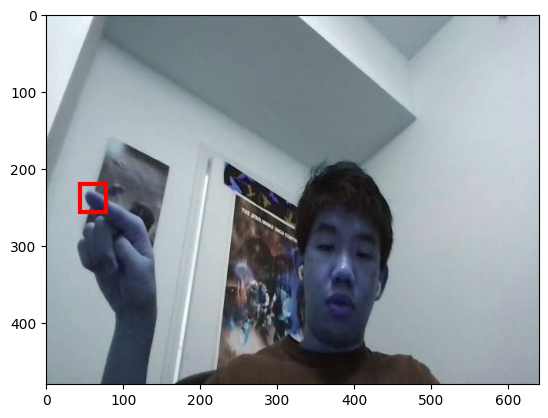

In [14]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))


show_corner_bb(im, bb)

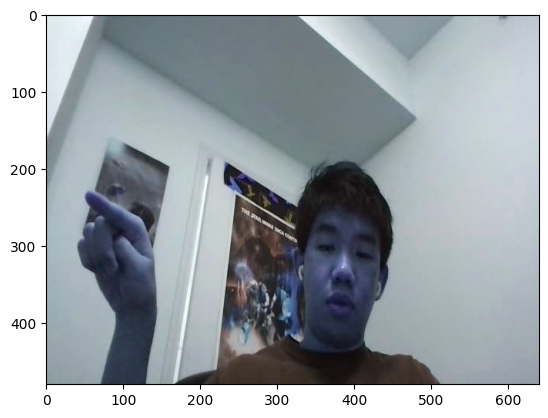

In [15]:
plt.imshow(im)

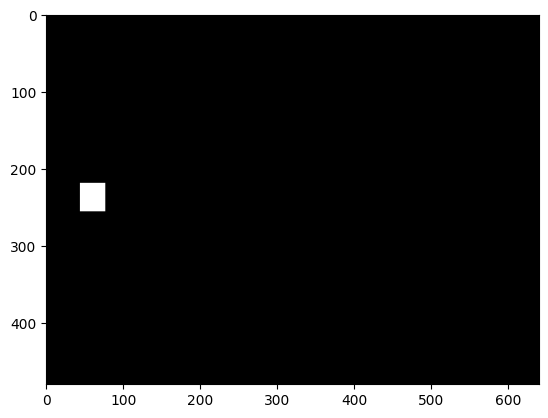

In [16]:
plt.imshow(Y, cmap='gray')

# Train-valid split


In [23]:
# df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
print(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

       new_path                        new_bb
0     23f45.jpg  [278.0, 135.0, 299.0, 164.0]
1     34f15.jpg  [177.0, 174.0, 196.0, 191.0]
2     10f10.jpg  [152.0, 146.0, 169.0, 172.0]
3     10f25.jpg   [128.0, 79.0, 146.0, 103.0]
4     10f40.jpg  [182.0, 179.0, 200.0, 198.0]
..          ...                           ...
981   100f6.jpg  [135.0, 342.0, 173.0, 381.0]
982   100f9.jpg  [137.0, 334.0, 176.0, 369.0]
983  100f12.jpg  [137.0, 310.0, 167.0, 345.0]
984  100f15.jpg  [123.0, 290.0, 160.0, 324.0]
985  100f18.jpg  [103.0, 297.0, 139.0, 327.0]

[986 rows x 2 columns]


# Dataset

In [18]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [24]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = load_and_preprocess(path, self.bb[idx])
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

def load_and_preprocess(path, bb):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    return x, mask_to_bb(Y)

train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, drop_last=True)

# Model

In [25]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()

        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

# Training

In [26]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [27]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 2.783 val_loss 309762.688 val_acc 0.000
train_loss 1.251 val_loss 596.573 val_acc 0.000
train_loss 0.731 val_loss 5.733 val_acc 0.599
train_loss 0.590 val_loss 0.528 val_acc 1.000
train_loss 0.455 val_loss 0.371 val_acc 1.000
train_loss 0.304 val_loss 0.250 val_acc 1.000
train_loss 0.231 val_loss 0.223 val_acc 1.000
train_loss 0.218 val_loss 0.214 val_acc 1.000
train_loss 0.206 val_loss 0.207 val_acc 1.000
train_loss 0.202 val_loss 0.203 val_acc 1.000
train_loss 0.186 val_loss 0.227 val_acc 1.000
train_loss 0.182 val_loss 0.220 val_acc 1.000
train_loss 0.176 val_loss 0.193 val_acc 1.000
train_loss 0.175 val_loss 0.215 val_acc 1.000
train_loss 0.169 val_loss 0.171 val_acc 1.000


0.16865386565526327

In [28]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.161 val_loss 0.167 val_acc 1.000
train_loss 0.160 val_loss 0.162 val_acc 1.000
train_loss 0.153 val_loss 0.158 val_acc 1.000
train_loss 0.146 val_loss 0.149 val_acc 1.000
train_loss 0.138 val_loss 0.142 val_acc 1.000
train_loss 0.132 val_loss 0.154 val_acc 1.000
train_loss 0.126 val_loss 0.156 val_acc 1.000
train_loss 0.119 val_loss 0.122 val_acc 1.000
train_loss 0.120 val_loss 0.143 val_acc 1.000
train_loss 0.111 val_loss 0.121 val_acc 1.000


0.11118087048331897

# Making Preditcions

[[139 134 158 154]]
[[147 144 167 165]]
[[146 148 166 169]]
[[152 150 173 171]]
[[149 136 169 157]]
[[126 116 144 135]]
[[132 124 151 143]]
[[148 150 168 172]]
[[168 169 190 192]]
[[184 173 206 197]]


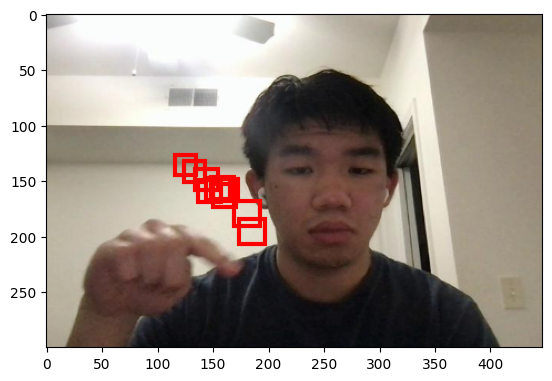

In [63]:

bounding = []
for i in range(0, 50, 5):
  # resizing test image
  im = read_image('/content/drive/My Drive/CS545/images/10f' + str(i) + '.jpg')
  im = cv2.resize(im, (int(1.49*300), 300))
  cv2.imwrite('testing.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
  # test Dataset
  test_ds = RoadDataset(pd.DataFrame([{'path':'testing.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
  x, y_class, y_bb = test_ds[0]
  xx = torch.FloatTensor(x[None,])
  xx.shape
  # prediction
  out_class, out_bb = model(xx.cuda())
  out_class, out_bb
  # predicted class
  torch.max(out_class, 1)
  def create_corner_rect(bb, color='red'):
      bb = np.array(bb, dtype=np.float32)
      return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                          fill=False, lw=3)

  def show_corner_bb(im, bb):
      plt.imshow(im)
      plt.gca().add_patch(create_corner_rect(bb))

  # predicted bounding box
  bb_hat = out_bb.detach().cpu().numpy()
  bb_hat = bb_hat.astype(int)
  print(bb_hat)
  bounding.append(bb_hat)
  show_corner_bb(im, bb_hat[0])

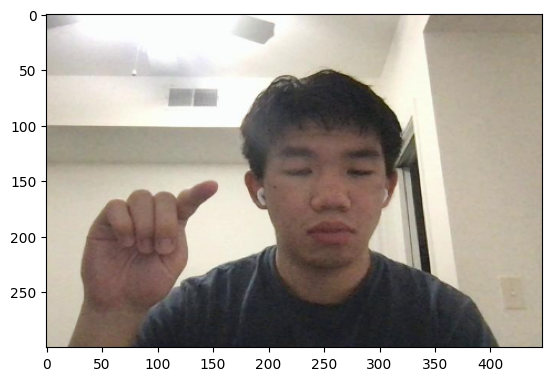

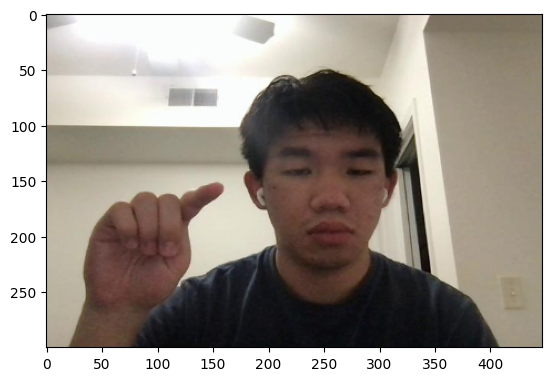

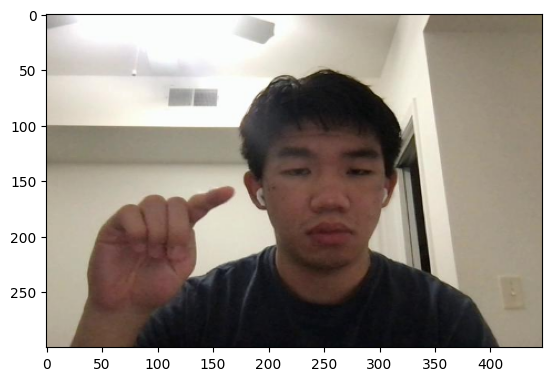

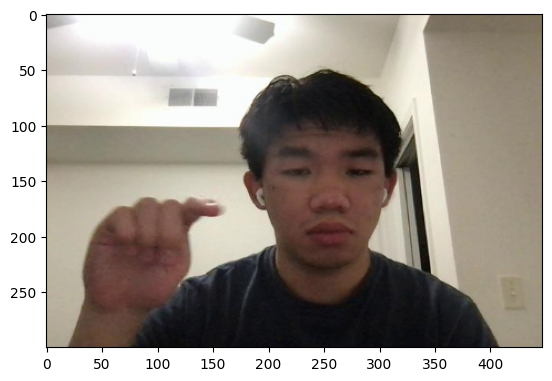

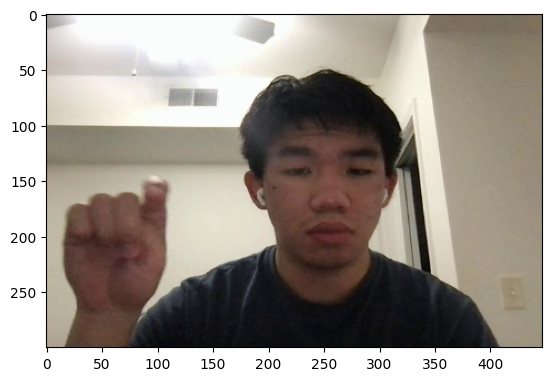

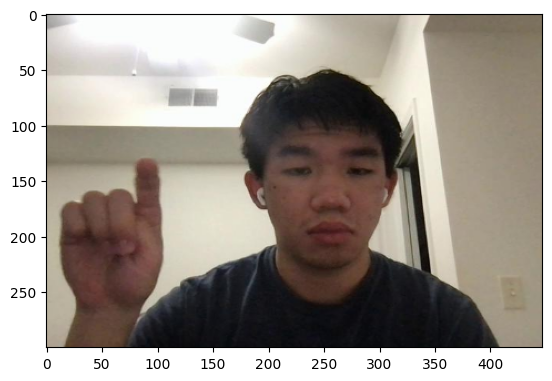

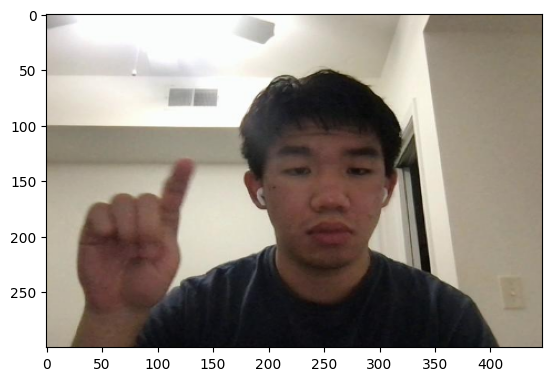

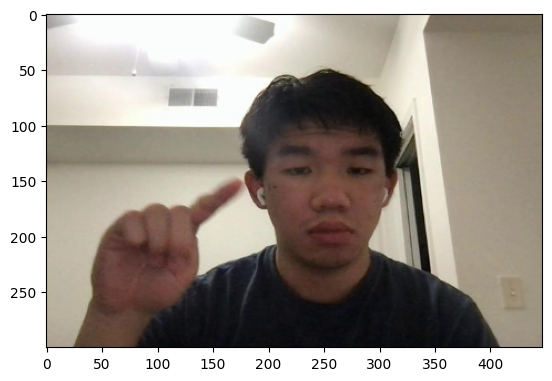

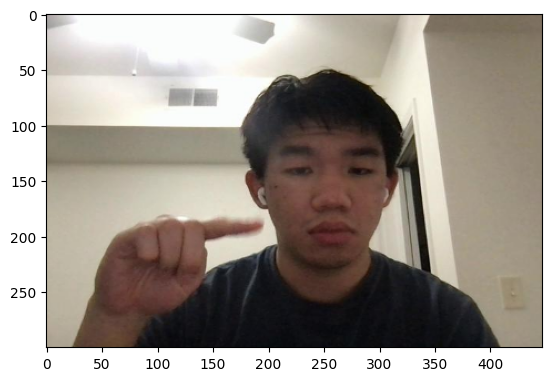

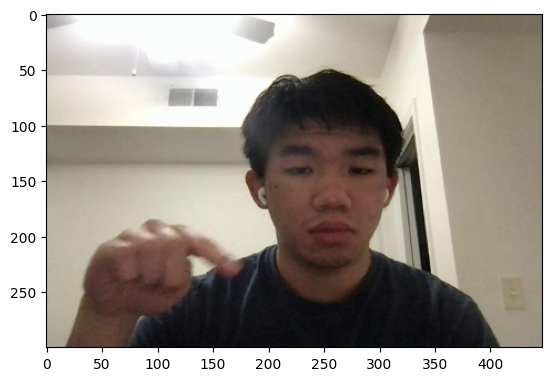

In [69]:
for i in range(0, 50, 5):
  im = read_image('/content/drive/My Drive/CS545/images/10f' + str(i) + '.jpg')
  im = cv2.resize(im, (int(1.49*300), 300))
  plt.figure()
  plt.imshow(im)
plt.show()

In [ ]:
# Method that takes a list of bounding boxes and appends it to a list to show where finger is
# Change THRESHOLD as needed
# bounding_boxes shoule be a list of [4]ints
def bb_to_coordinate_frame(bounding_boxes, probabilities, THRESHOLD=0.5):
    # Error Checking
    if len(bounding_boxes) != len(probabilities):
        print("Error in format of bounding boxes and probabilities")
        print("Bounding boxes should be like [[pt1.x, pt1.y, pt2.x, pt2.y], ...]")
        print("Probabilities  should be like [p1, p2, p3, ..., pn]")
        return None

    n = len(probabilities)

    fingerPlacements = []
    DNE = [-1, -1, -1, -1]
    for i in range(n):
        if probabilities[i] > THRESHOLD:
            bounding_boxes_x = (bounding_boxes[0] + bounding_boxes[2]) / 2
            bounding_boxes_y = (bounding_boxes[1] + bounding_boxes[3]) / 2
            fingerPlacements.extend([bounding_boxes_x, bounding_boxes_y])
        else:
            fingerPlacements.extend(DNE)

    if len(fingerPlacements) != 4 * n:
        print("Not enough bounding boxes were added. Check that you added all the frames")
        print("Actual", len(fingerPlacements), "- Expected", 4 * n)
        return None

    return fingerPlacements

def computeGaussian(x, mean, covariance, dim):
  # print(x.shape, mean.shape)
  exponent = -.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(covariance)), (x - mean))
  numerator = np.exp(exponent)
  denominator = (2 * np.pi)**dim * np.linalg.det(covariance)**.5

  return numerator / (denominator)

In [ ]:
num_training = 120
num_testing = 40
num_classes = 4
num_components = 20
num_per_class = 10

from sklearn.decomposition import PCA

# Get bounding box into one list
fingerPlacementsTraining = bb_to_coordinate_frame(None, None)
fingerPlacementsTesting = bb_to_coordinate_frame(None, None)

# Perform PCA
training = fingerPlacementsTraining.reshape(num_training, -1)
testing = fingerPlacementsTesting.reshape(num_testing, -1)

normalized_training = training - np.mean(training)
normalized_testing = testing - np.mean(testing)

pca = PCA(n_components = num_components)
pca.fit(normalized_training)
reduced_testing = pca.transform(normalized_testing)


# Create gaussians
direction_means = []
direction_covariances = []
for i in range(num_classes):
    start = int(i * num_per_class)
    end = int((i+1) * num_per_class)
    direction_training = pca.transform(normalized_training[start:end])

    direction_means.append(np.mean(direction_training, axis=0))
    direction_covariances.append(np.cov(direction_training, rowvar=False))

# Perform Evaluation
classified = []
for each in reduced_testing:
    classifications = []
    for i in range(num_classes):
        classifications.append(computeGaussian(each, direction_means[i], direction_covariances[i], num_components))
    classified.append(np.argmax(classifications))

# Count correctness
correct = 0
for i, each in enumerate(classified):
    if i < 10:
        if each == 0:
            correct += 1
    elif i < 20:
        if each == 1:
            correct += 1
    elif i < 30:
        if each == 2:
            correct += 1
    else:
        if each == 3:
            correct += 1

print(correct/num_testing)